In [19]:
import numpy as np
import os
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf


from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model



In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='best_model_dum_rmsle.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



In [22]:
import tensorflow.keras.backend as K
def rmsle(y_true, y_pred):
    """
    Compute Root Mean Squared Logarithmic Error.

    Parameters:
    y_true -- true values
    y_pred -- predicted values
    """
    log_true = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    log_pred = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(log_true - log_pred)))

def rmsle_loss():
    return rmsle

# Example usage of custom loss function
loss_function = rmsle_loss()


In [23]:
vgg_df = pd.read_csv('vgg_2.csv')
full_count_df = pd.read_csv('full_count.csv')

# Assuming both DataFrames have an 'id' column to match the entries
# Merge on 'id' to filter out labels without corresponding features
merged_df = pd.merge(vgg_df, full_count_df, on='id')
merged_df = vgg_df.merge(full_count_df[['id', 'average']], on='id', how='left')
merged_df =merged_df.dropna()
merged_df


,Unnamed: 0,id,0,1,2,3,4,5,6,7,...,25079,25080,25081,25082,25083,25084,25085,25086,25087,average
0,0,0R3102@37,12.539886,0.000000,0.0,0.0,0.000000,0.0,0.0,1.476546,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,14.415866,0.0,122126.620499
1,1,004203@29,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,10648.015773
2,2,000153@45,6.865058,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,3502.118785
3,3,00034B@34,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,27903.432507
4,4,0W7501@37,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,4.508424,0.0,23365.595989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19273,19273,000674@49,70.362850,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,12.846828,0.0,0.0,8.445571,0.0,186462.840456
19274,19274,0R9111@37,14.250834,0.000000,0.0,0.0,0.000000,0.0,0.0,27.785362,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,13.963306,0.0,135871.500000
19275,19275,005182@36,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,3.291706,20.477950,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,10711.833333
19278,19278,050048@51,3.144773,11.913834,0.0,0.0,10.343277,0.0,0.0,0.000000,...,0.000000,17.589960,0.0,0.0,0.000000,0.0,0.0,3.563257,0.0,7079.732782


In [24]:
X = merged_df.drop(columns=['Unnamed: 0','id', "average"]).values  # Adjust 'label' to the actual column name in full_count_df for labels
y = merged_df['average'].values.squeeze()  # Adjust 'label' to the actual column name in full_count_df for labels


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss=rmsle)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[checkpoint_callback])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict using the model
predictions = model.predict(X_test)

Epoch 1/50
342/345 [============================>.] - ETA: 0s - loss: 3.6891
Epoch 1: val_loss improved from inf to 1.70581, saving model to best_model_dum_rmsle.h5
345/345 [==============================] - 8s 18ms/step - loss: 3.6773 - val_loss: 1.7058
Epoch 2/50
  5/345 [..............................] - ETA: 4s - loss: 1.6139

c:\Users\hec_m\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


345/345 [==============================] - ETA: 0s - loss: 1.2537
Epoch 2: val_loss improved from 1.70581 to 1.09814, saving model to best_model_dum_rmsle.h5
345/345 [==============================] - 6s 17ms/step - loss: 1.2537 - val_loss: 1.0981
Epoch 3/50
344/345 [============================>.] - ETA: 0s - loss: 0.9486
Epoch 3: val_loss improved from 1.09814 to 1.00412, saving model to best_model_dum_rmsle.h5
345/345 [==============================] - 6s 17ms/step - loss: 0.9485 - val_loss: 1.0041
Epoch 4/50
344/345 [============================>.] - ETA: 0s - loss: 0.8268
Epoch 4: val_loss improved from 1.00412 to 0.96453, saving model to best_model_dum_rmsle.h5
345/345 [==============================] - 6s 18ms/step - loss: 0.8269 - val_loss: 0.9645
Epoch 5/50
343/345 [============================>.] - ETA: 0s - loss: 0.7270
Epoch 5: val_loss improved from 0.96453 to 0.94533, saving model to best_model_dum_rmsle.h5
345/345 [==============================] - 7s 21ms/step - loss: 0

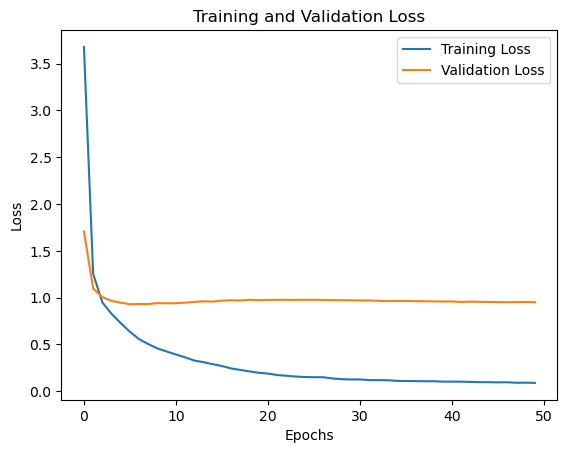

In [27]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [28]:
from tensorflow.keras.models import load_model
best_model = None
with tf.keras.utils.custom_object_scope({'rmsle': rmsle}):
    best_model = load_model('best_model_dum_rmsle.h5')


In [29]:

from sklearn.metrics import mean_absolute_error, mean_squared_error


loss = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

def rmsle_eval(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))

rmsle_score = rmsle_eval(y_test, predictions)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSLE: {rmsle_score}')

108/108 [==============================] - 1s 3ms/step - loss: 0.9207
Test Loss: 0.920746922492981
108/108 [==============================] - 0s 3ms/step
MSE: 1130084125.6377232
MAE: 18849.78278068944
RMSLE: 1.754949600925864


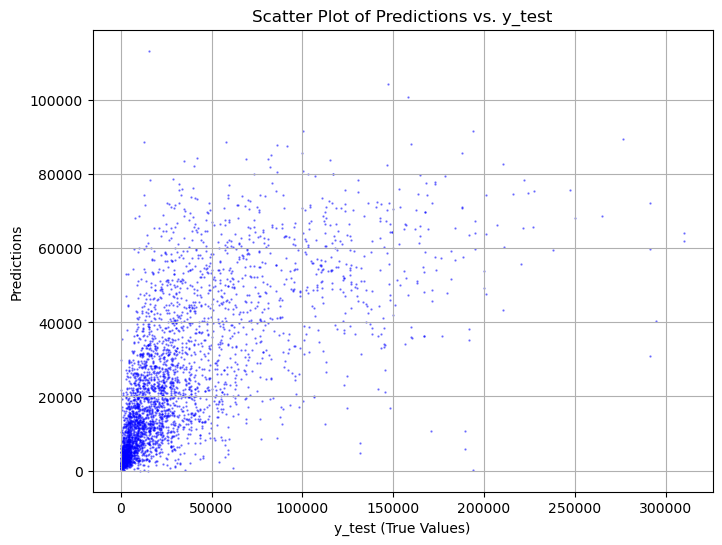

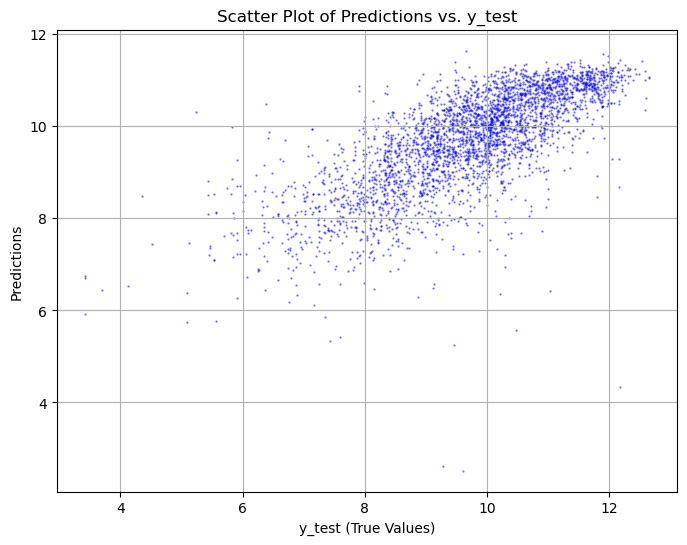

In [30]:
import matplotlib.pyplot as plt
import numpy as np



# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.5, s=0.4)
plt.title('Scatter Plot of Predictions vs. y_test')
plt.xlabel('y_test (True Values)')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()


# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(np.log(y_test), np.log(predictions), color='blue', alpha=0.5, s=0.4)
plt.title('Scatter Plot of Predictions vs. y_test')
plt.xlabel('y_test (True Values)')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()


